In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def evaluate(tp, tn, fp, fn):
    if (tp + tn + fp + fn) > 0:
        acc = (tp + tn) / (tp + tn + fp + fn)
    else:
        acc = 0

    if (tp + fp) > 0:
        pre = tp / (tp + fp)
    else:
        pre = 0

    if (tp + fn) > 0:
        rec = tp / (tp + fn)
    else:
        rec = 0

    if (pre + rec) > 0:
        f_score = (2 * pre * rec) / (pre + rec)
    else:
        f_score = 0
        
    if (fp + tn) > 0:
        fp_rate = fp / (fp + tn)
    else:
        fp_rate = 0
    
    return acc, pre, rec, f_score, fp_rate

In [4]:
data_url = "hr-employee-attrition-with-null.csv"
data = pd.read_csv("hr-employee-attrition-with-null.csv", index_col=0)

In [5]:
data.loc[data["Attrition"] == "No", "Attrition"] = 0.0
data.loc[data["Attrition"] == "Yes", "Attrition"] = 1.0

for col in ["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus", "Over18", "OverTime"]:
    data[col] = pd.Categorical(data[col]).codes

data = data.drop(columns = "EmployeeNumber")

In [6]:
attr_yes = data[data["Attrition"] == 1.0]
attr_no = data[data["Attrition"] == 0.0]

sy = attr_yes.shape[0] // 10
sn = attr_no.shape[0] // 10

test_set = pd.concat([attr_yes[:sy], attr_no[:sn]])
train_set = pd.concat([attr_yes[sy:], attr_no[sn:]])

train_leave = train_set[train_set["Attrition"] == 1.0]
train_stay = train_set[train_set["Attrition"] == 0.0]

train_set = train_set.drop(columns = "Attrition")

## T4. Histogram discretization & T5. Count the zero bins

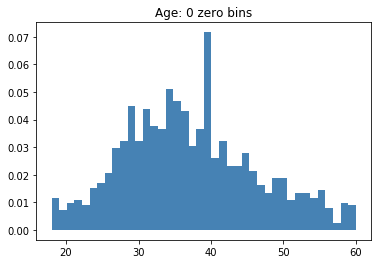

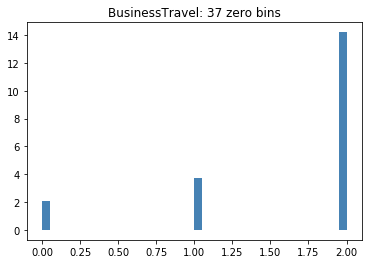

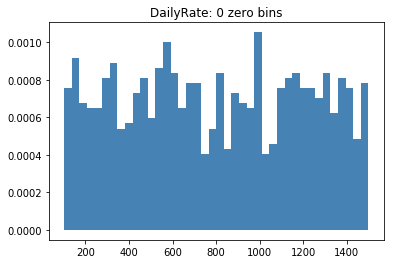

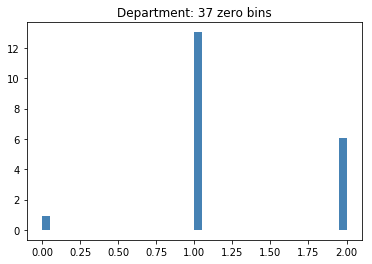

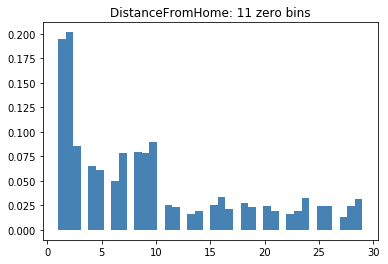

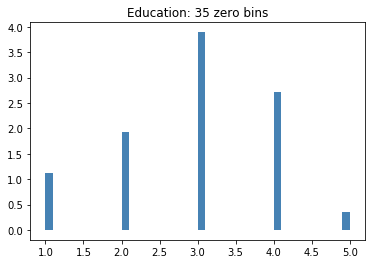

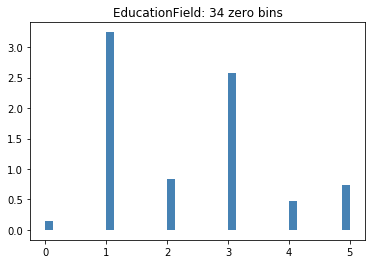

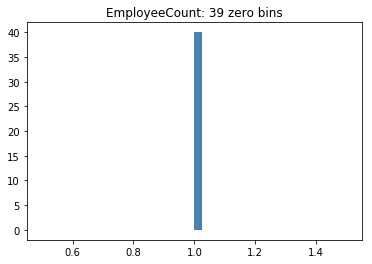

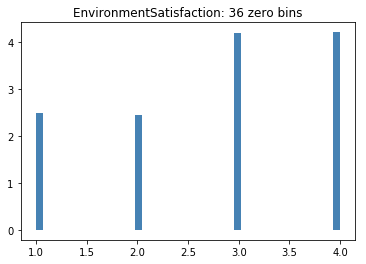

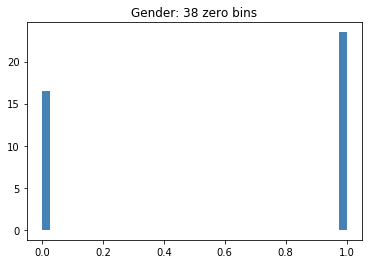

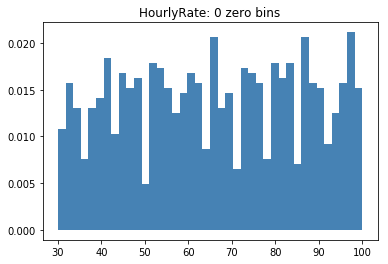

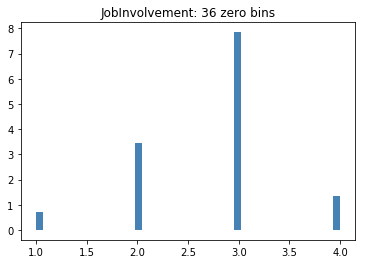

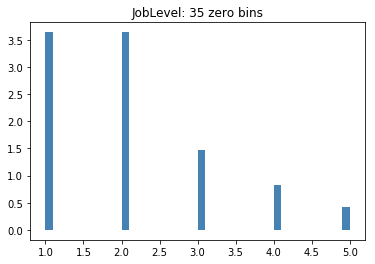

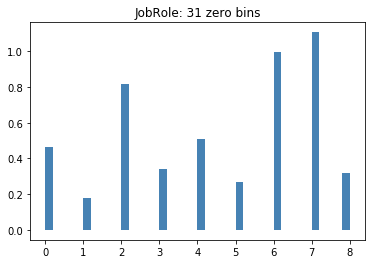

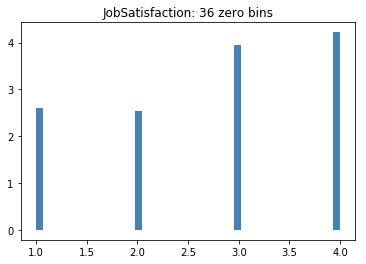

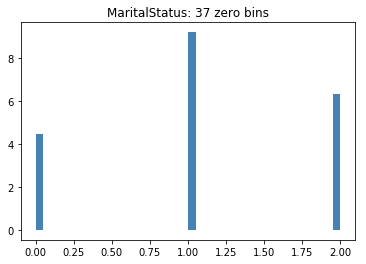

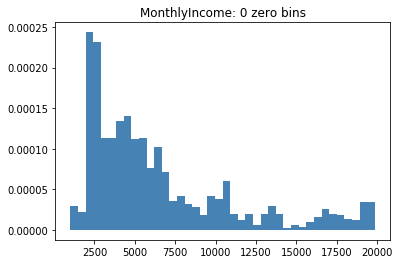

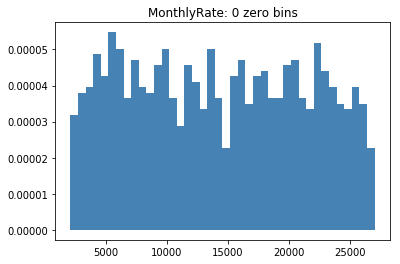

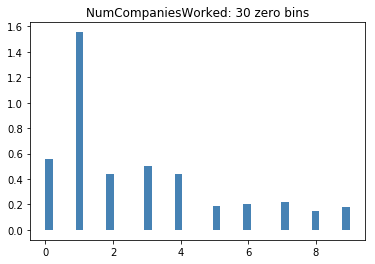

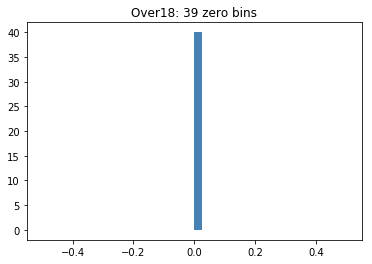

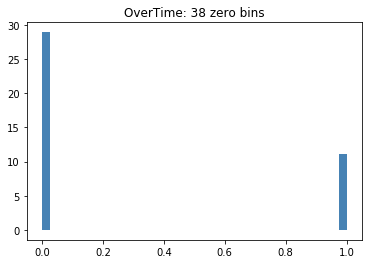

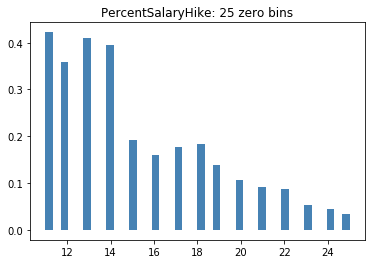

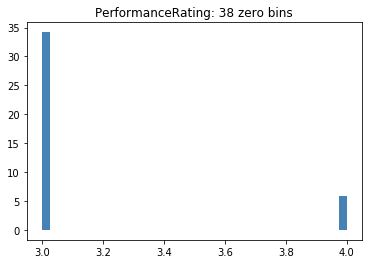

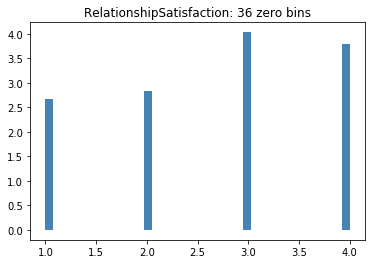

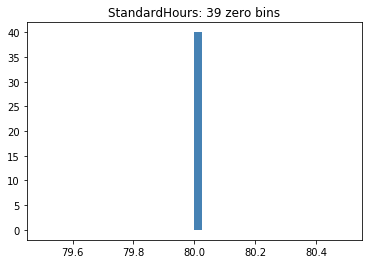

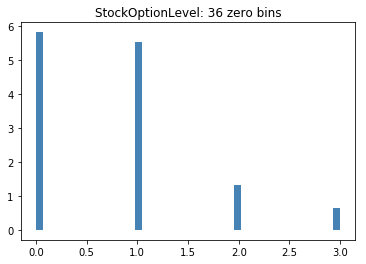

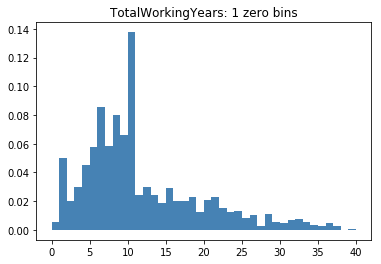

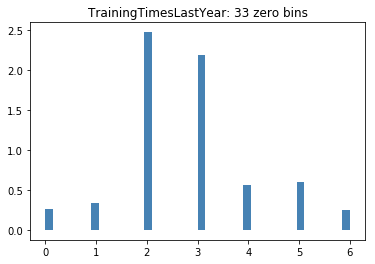

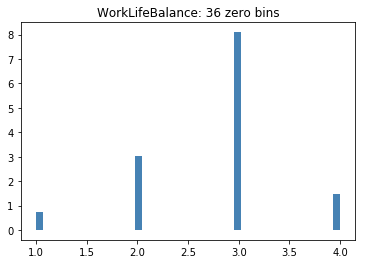

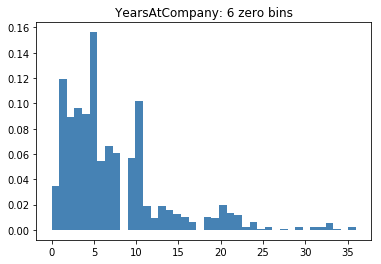

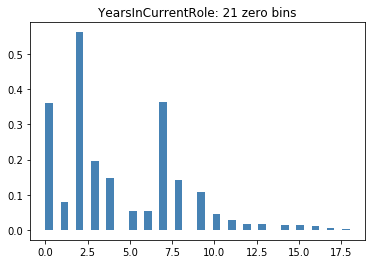

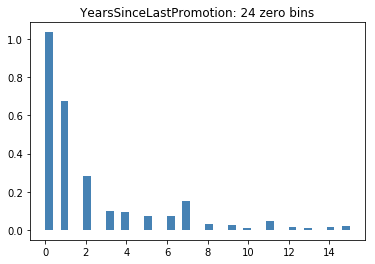

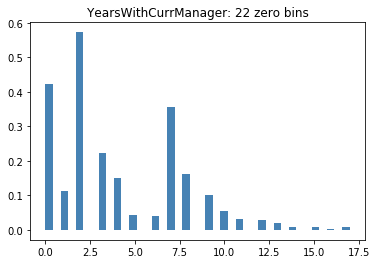

In [7]:
cnt = 0
for col in train_set:
    train_col_no_nan = train_set[~np.isnan(train_set[col])][col]
    train_col_no_nan = train_col_no_nan[train_col_no_nan != -1]
    
    hist, bin_edge = np.histogram(train_col_no_nan, 40, density=True)
    cnt += len(hist[hist == 0])
    
    plt.title(col + ": %d" % len(hist[hist == 0]) + " zero bins")
    plt.fill_between(bin_edge.repeat(2)[1:-1], hist.repeat(2),facecolor='steelblue')
    plt.show()

In [8]:
print("There are %d bins with zero count in all features" % cnt)

There are 866 bins with zero count in all features


## T6. 10, 40 and 100 bins size for Age, MonthlyIncome and DistanceFromHome

### 10 bins size

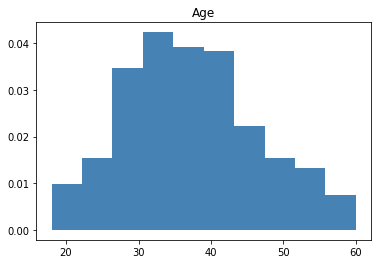

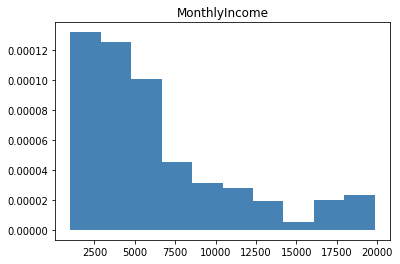

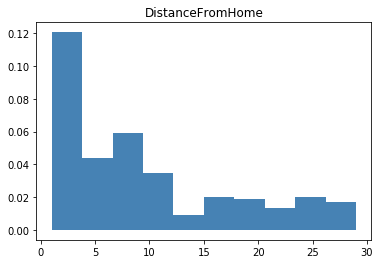

In [9]:
for col in ["Age", "MonthlyIncome", "DistanceFromHome"]:
    train_col_no_nan = train_set[~np.isnan(train_set[col])][col]
    train_col_no_nan = train_col_no_nan[train_col_no_nan != -1]
    
    hist, bin_edge = np.histogram(train_col_no_nan, 10, density=True)

    plt.title(col)
    plt.fill_between(bin_edge.repeat(2)[1:-1], hist.repeat(2),facecolor='steelblue')
    plt.show()

### 40 bins size

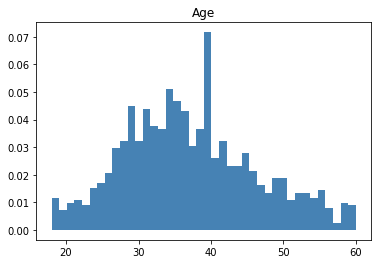

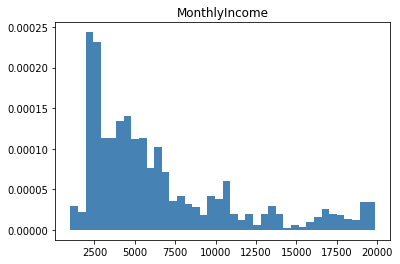

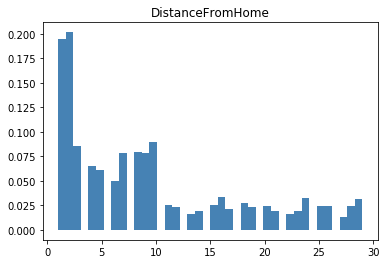

In [10]:
for col in ["Age", "MonthlyIncome", "DistanceFromHome"]:
    train_col_no_nan = train_set[~np.isnan(train_set[col])][col]
    train_col_no_nan = train_col_no_nan[train_col_no_nan != -1]
    
    hist, bin_edge = np.histogram(train_col_no_nan, 40, density=True)

    plt.title(col)
    plt.fill_between(bin_edge.repeat(2)[1:-1], hist.repeat(2),facecolor='steelblue')
    plt.show()

### 100 bins size

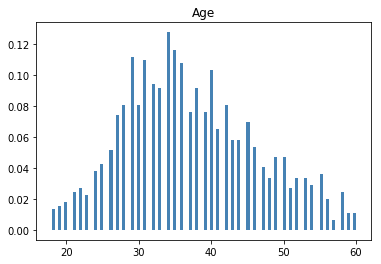

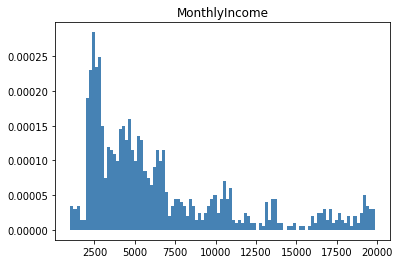

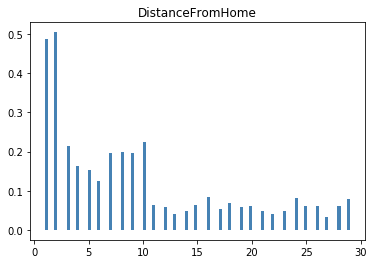

In [11]:
for col in ["Age", "MonthlyIncome", "DistanceFromHome"]:
    train_col_no_nan = train_set[~np.isnan(train_set[col])][col]
    train_col_no_nan = train_col_no_nan[train_col_no_nan != -1]
    
    hist, bin_edge = np.histogram(train_col_no_nan, 100, density=True)

    plt.title(col)
    plt.fill_between(bin_edge.repeat(2)[1:-1], hist.repeat(2),facecolor='steelblue')
    plt.show()

## T7. Find features that should be discretized

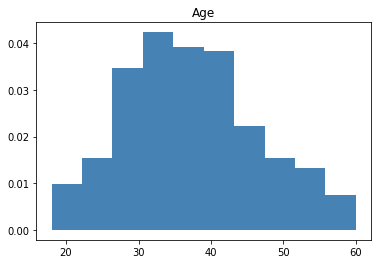

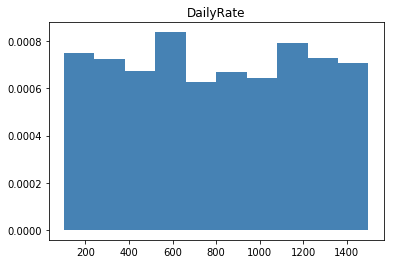

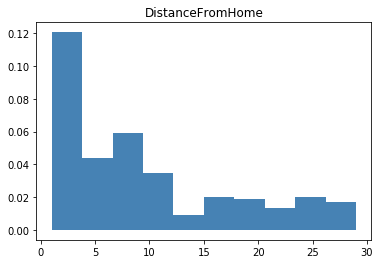

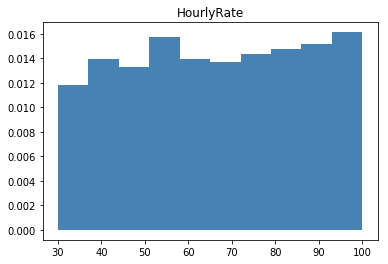

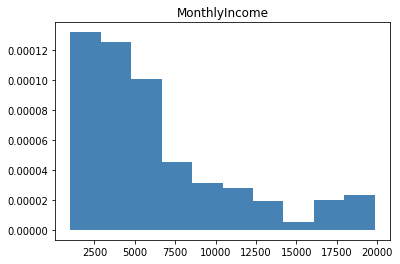

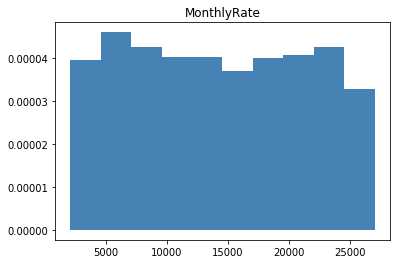

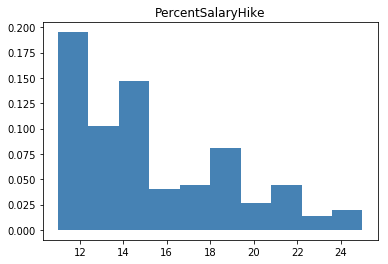

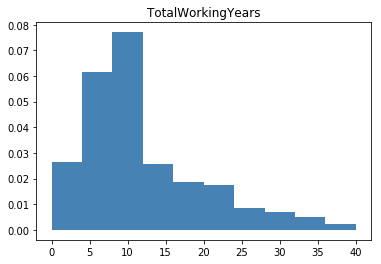

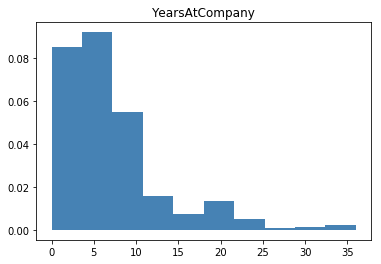

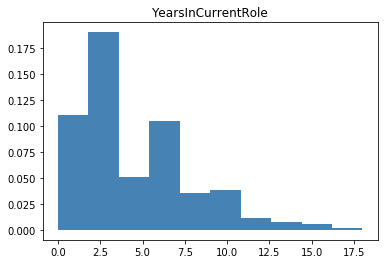

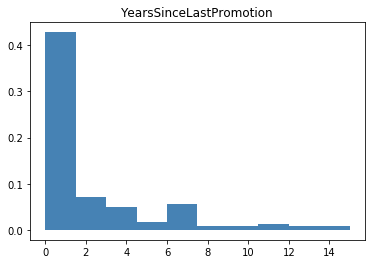

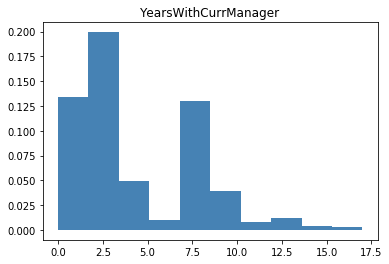

In [12]:
for col in train_set:
    
    train_col_no_nan = train_set[~np.isnan(train_set[col])][col]
    train_col_no_nan = train_col_no_nan[train_col_no_nan != -1]
    
    if len(np.unique(train_col_no_nan)) > 10:
        hist, bin_edge = np.histogram(train_col_no_nan, 10, density=True)

        plt.title(col)
        plt.fill_between(bin_edge.repeat(2)[1:-1], hist.repeat(2),facecolor='steelblue')
        plt.show()

## T8. The MLE for the likelihood distribution of discretized histograms

### Find the MLE for each feature
- Since the MLE of each feature might be underflow, so It's better to change to find log likelihood instead.

In [13]:
bin_edge = {}
llh_leave = {}
llh_stay = {}

for col in train_set:
    train_col_no_nan = train_set[~np.isnan(train_set[col])][col]
    train_col_no_nan = train_col_no_nan[train_col_no_nan != -1]

    leave = train_leave[~np.isnan(train_leave[col])][col]
    leave = leave[leave != -1]
    
    stay = train_stay[~np.isnan(train_stay[col])][col]
    stay = stay[stay != -1]

    hist, bin_edge[col] = np.histogram(train_col_no_nan, min(len(np.unique(train_col_no_nan)), 10))
    h_leave = np.histogram(leave, bin_edge[col], density=True)[0]
    h_stay = np.histogram(stay, bin_edge[col], density=True)[0]
    
    llh_leave[col] = h_leave
    llh_stay[col] = h_stay
    
    gap = bin_edge[col][1] - bin_edge[col][0]
    n_leave = len(leave) * h_leave[h_leave != 0] * gap
    n_stay = len(stay) * h_stay[h_stay != 0] * gap
    
    log_l = sum(n_leave * np.log(h_leave[h_leave != 0])) + sum(n_stay * np.log(h_stay[h_stay != 0]))
    
    print(col, log_l)

Age -3785.0879054381235
BusinessTravel -396.3326783197142
DailyRate -7661.178784619351
Department -391.7755023527906
DistanceFromHome -3178.333266579287
Education -1242.639623889973
EducationField -1314.9671154485416
EmployeeCount 0.0
EnvironmentSatisfaction -1119.7973892670493
Gender 16.573910900540362
HourlyRate -4471.012007186432
JobInvolvement -799.9531869790566
JobLevel -1170.4318402627673
JobRole -2013.5214671083954
JobSatisfaction -1125.0019821432863
MaritalStatus -672.7458462590105
MonthlyIncome -10064.765250621977
MonthlyRate -10681.409621966524
NumCompaniesWorked -2000.4964495024828
Over18 0.0
OverTime 131.05683244481162
PercentSalaryHike -2503.5497335085247
PerformanceRating 295.0381004653255
RelationshipSatisfaction -1149.6860901208167
StandardHours 0.0
StockOptionLevel -841.1455293425629
TotalWorkingYears -3457.9766689224703
TrainingTimesLastYear -1488.2994742537448
WorkLifeBalance -798.303045844618
YearsAtCompany -3047.1287837445057
YearsInCurrentRole -2497.5952507500465


### Plot the likelihood distributions of MonthlyIncome, JobRole, HourlyRate, and MaritalStatus

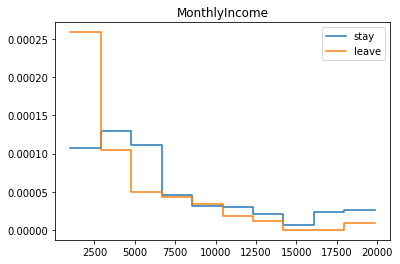

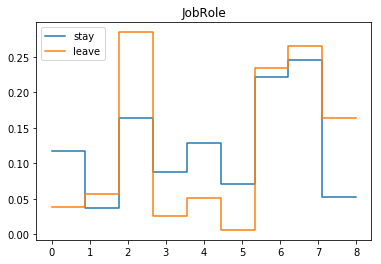

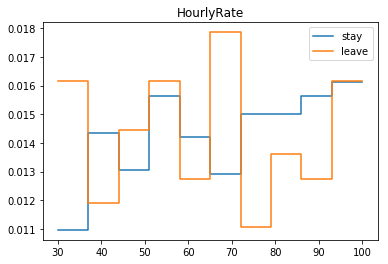

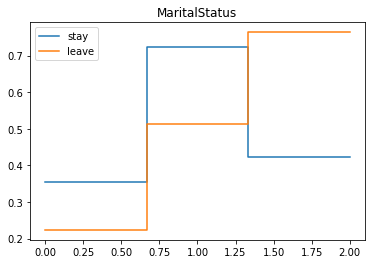

In [14]:
for col in ["MonthlyIncome", "JobRole", "HourlyRate", "MaritalStatus"]:
    leave = train_leave[~np.isnan(train_leave[col])][col]
    leave = leave[leave != -1]
    
    stay = train_stay[~np.isnan(train_stay[col])][col]
    stay = stay[stay != -1]

    h_leave = np.histogram(leave, bin_edge[col], density=True)[0]
    h_stay = np.histogram(stay, bin_edge[col], density=True)[0]

    x = []
    y_leave = []
    y_stay = []

    for i in range (len(h_leave)):
        x += [bin_edge[col][i], bin_edge[col][i+1]]
        y_leave += [h_leave[i]] * 2
        y_stay += [h_stay[i]] * 2

    plt.title(col)
    plt.plot(x, y_stay)
    plt.plot(x, y_leave)
    plt.legend(['stay', 'leave'])
    plt.show()

## T9. Find prior distribution of the 2 classes

In [15]:
p_leave = len(train_leave) / len(train_set)
p_stay = len(train_stay) / len(train_set)

print("Leave: %.2f %%" % (p_leave*100))
print("Stay: %.2f %%" % (p_stay*100))

Leave: 16.16 %
Stay: 83.84 %


## T10. Naive Bayes classification

In [18]:
tp = 0
tn = 0
fp = 0
fn = 0
log_h_d = {}

for i in range (len(test_set)):
    test = test_set[i:i+1]
    
    log_h_d[i] = np.log(p_leave) - np.log(p_stay)
    
    for col in train_set:
        value = test[col].values[0]
        
        if np.isnan(value) or value == -1:
            continue
            
        n_bin = np.digitize(value, bin_edge[col]) - 1
        n_bin = np.clip(n_bin, 0, len(bin_edge[col]) - 2)
        
        p_x_leave = llh_leave[col][n_bin]
        p_x_stay = llh_stay[col][n_bin]

        if p_x_leave > 0:
            log_h_d[i] += np.log(p_x_leave)
        if p_x_stay > 0:
            log_h_d[i] -= np.log(p_x_stay)
    
    if test["Attrition"].values[0] == 1 and log_h_d[i] >= 0:
        tp += 1
    elif test["Attrition"].values[0] == 0 and log_h_d[i] < 0:
        tn += 1
    elif test["Attrition"].values[0] == 1 and log_h_d[i] < 0:
        fn += 1
    elif test["Attrition"].values[0] == 0 and log_h_d[i] >= 0:
        fp += 1
    print(tp,tn,fn,fp)

0 0 1 0
1 0 1 0
2 0 1 0
2 0 2 0
2 0 3 0
3 0 3 0
3 0 4 0
4 0 4 0
5 0 4 0
6 0 4 0
6 0 5 0
7 0 5 0
8 0 5 0
9 0 5 0
9 0 6 0
9 0 7 0
10 0 7 0
10 0 8 0
10 0 9 0
10 0 10 0
10 0 11 0
10 0 12 0
11 0 12 0
11 1 12 0
11 2 12 0
11 3 12 0
11 4 12 0
11 4 12 1
11 4 12 2
11 5 12 2
11 6 12 2
11 7 12 2
11 8 12 2
11 9 12 2
11 10 12 2
11 11 12 2
11 12 12 2
11 12 12 3
11 12 12 4
11 13 12 4
11 14 12 4
11 15 12 4
11 15 12 5
11 16 12 5
11 17 12 5
11 18 12 5
11 19 12 5
11 19 12 6
11 20 12 6
11 20 12 7
11 21 12 7
11 21 12 8
11 21 12 9
11 22 12 9
11 23 12 9
11 24 12 9
11 25 12 9
11 26 12 9
11 26 12 10
11 27 12 10
11 28 12 10
11 28 12 11
11 29 12 11
11 30 12 11
11 30 12 12
11 30 12 13
11 31 12 13
11 32 12 13
11 33 12 13
11 34 12 13
11 35 12 13
11 36 12 13
11 37 12 13
11 38 12 13
11 39 12 13
11 40 12 13
11 41 12 13
11 42 12 13
11 43 12 13
11 44 12 13
11 45 12 13
11 45 12 14
11 46 12 14
11 47 12 14
11 48 12 14
11 49 12 14
11 50 12 14
11 51 12 14
11 52 12 14
11 53 12 14
11 54 12 14
11 55 12 14
11 56 12 14
11 57 12 14

In [19]:
acc, pre, rec, f_score, fp_rate = evaluate(tp, tn, fp, fn)

print("Accuracy: %.2f %%" % (acc*100))
print("Precision: %.2f %%" % (pre*100))
print("Recall: %.2f %%" % (rec*100))
print("F-score: %.2f %%" % (f_score*100))

Accuracy: 73.97 %
Precision: 29.73 %
Recall: 47.83 %
F-score: 36.67 %


## T11. Assume the features are normally distributed

In [22]:
leave_norm = {}
stay_norm = {}
for col in train_set:
    leave = train_leave[~np.isnan(train_leave[col])][col]
    leave = leave[leave != -1]
    
    stay = train_stay[~np.isnan(train_stay[col])][col]
    stay = stay[stay != -1]
    
    leave_norm[col] = norm(leave.mean(), leave.std())
    stay_norm[col] = norm(stay.mean(), stay.std())

In [23]:
tp = 0
tn = 0
fp = 0
fn = 0
log_h_n = {}

for i in range (len(test_set)):
    test = test_set[i:i+1]
    
    log_h_n[i] = np.log(p_leave) - np.log(p_stay)
    
    for col in train_set:
        value = test[col].values[0]
        
        if np.isnan(value) or value == -1:
            continue
        
        p_x_leave = leave_norm[col].pdf(value)
        p_x_stay = stay_norm[col].pdf(value)

        if p_x_leave > 0:
            log_h_n[i] += np.log(p_x_leave)
        if p_x_stay > 0:
            log_h_n[i] -= np.log(p_x_stay)
    
    if test["Attrition"].values[0] == 1 and log_h_n[i] >= 0:
        tp += 1
    elif test["Attrition"].values[0] == 0 and log_h_n[i] < 0:
        tn += 1
    elif test["Attrition"].values[0] == 1 and log_h_n[i] < 0:
        fn += 1
    elif test["Attrition"].values[0] == 0 and log_h_n[i] >= 0:
        fp += 1
print(tp, tn, fn, fp)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


15 105 8 18


In [24]:
acc, pre, rec, f_score, fp_rate = evaluate(tp, tn, fp, fn)

print("Accuracy: %.2f %%" % (acc*100))
print("Precision: %.2f %%" % (pre*100))
print("Recall: %.2f %%" % (rec*100))
print("F-score: %.2f %%" % (f_score*100))

Accuracy: 82.19 %
Precision: 45.45 %
Recall: 65.22 %
F-score: 53.57 %


## T12. Predict by using the random choice baseline

In [ ]:
tp = 0
tn = 0
fp = 0
fn = 0

for i in range (len(test_set)):
    test = test_set[i:i+1]
    predict = np.random.random() > 0.5
    
    if test["Attrition"].values[0] == 1 and predict:
        tp += 1
    elif test["Attrition"].values[0] == 0 and not predict:
        tn += 1
    elif test["Attrition"].values[0] == 1 and not predict:
        fn += 1
    elif test["Attrition"].values[0] == 0 and predict:
        fp += 1

In [ ]:
acc, pre, rec, f_score, fp_rate = evaluate(tp, tn, fp, fn)

print("Accuracy: %.2f %%" % (acc*100))
print("Precision: %.2f %%" % (pre*100))
print("Recall: %.2f %%" % (rec*100))
print("F-score: %.2f %%" % (f_score*100))

## T13. Predict by using the majority rule baseline

In [40]:
tp = 0
tn = 0
fp = 0
fn = 0

predict = len(train_leave) > len(train_stay)
for i in range (len(test_set)):
    test = test_set[i:i+1]
    
    if test["Attrition"].values[0] == 1 and predict:
        tp += 1
    elif test["Attrition"].values[0] == 0 and not predict:
        tn += 1
    elif test["Attrition"].values[0] == 1 and not predict:
        fn += 1
    elif test["Attrition"].values[0] == 0 and predict:
        fp += 1

In [41]:
acc, pre, rec, f_score, fp_rate = evaluate(tp, tn, fp, fn)

print("Accuracy: %.2f %%" % (acc*100))
print("Precision: %.2f %%" % (pre*100))
print("Recall: %.2f %%" % (rec*100))
print("F-score: %.2f %%" % (f_score*100))

Accuracy: 84.25 %
Precision: 0.00 %
Recall: 0.00 %
F-score: 0.00 %


## T15. Threshold finding

### Discrete distribution

In [42]:
y_acc = []
y_fsc = []

fpr_dis = []
tpr_dis = []

max_acc = 0
t_acc = 0
max_fsc = 0
t_fsc = 0

for t in np.arange(-5, 5, 0.05):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i in range (len(test_set)):
        test = test_set[i:i+1]

        if test["Attrition"].values[0] == 1 and log_h_d[i] >= t:
            tp += 1
        elif test["Attrition"].values[0] == 0 and log_h_d[i] < t:
            tn += 1
        elif test["Attrition"].values[0] == 1 and log_h_d[i] < t:
            fn += 1
        elif test["Attrition"].values[0] == 0 and log_h_d[i] >= t:
            fp += 1
    
    acc, pre, rec, f_score, fp_rate = evaluate(tp, tn, fp, fn)
    
    y_acc += [acc]
    y_fsc += [f_score]
    
    fpr_dis += [fp_rate]
    tpr_dis += [rec]
    
    if acc > max_acc:
        max_acc = acc
        t_acc = t
    
    if f_score > max_fsc:
        max_fsc = f_score
        t_fsc = t

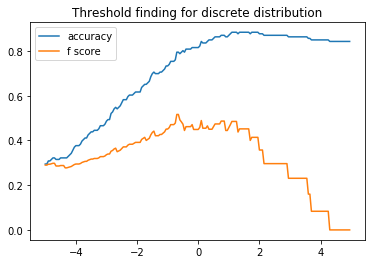

Best Accuracy: 88.36 % at Threshold 1.10
Best F-score: 51.61 % at Threshold -0.70


In [43]:
plt.title("Threshold finding for discrete distribution")
plt.plot(np.arange(-5, 5, 0.05), y_acc)
plt.plot(np.arange(-5, 5, 0.05), y_fsc)
plt.legend(['accuracy', 'f score'])
plt.show()

print("Best Accuracy: %.2f %% at Threshold %.2f" % (max_acc*100, t_acc))
print("Best F-score: %.2f %% at Threshold %.2f" % (max_fsc*100, t_fsc))

### Normal distribution

In [52]:
y_acc = []
y_fsc = []

fpr_nor = []
tpr_nor = []

max_acc = 0
t_acc = 0
max_fsc = 0
t_fsc = 0

for t in np.arange(-5, 5, 0.05):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i in range (len(test_set)):
        test = test_set[i:i+1]

        if test["Attrition"].values[0] == 1 and log_h_n[i] >= t:
            tp += 1
        elif test["Attrition"].values[0] == 0 and log_h_n[i] < t:
            tn += 1
        elif test["Attrition"].values[0] == 1 and log_h_n[i] < t:
            fn += 1
        elif test["Attrition"].values[0] == 0 and log_h_n[i] >= t:
            fp += 1
    
    acc, pre, rec, f_score, fp_rate = evaluate(tp, tn, fp, fn)
    
    y_acc += [acc]
    y_fsc += [f_score]
    
    fpr_nor += [fp_rate]
    tpr_nor += [rec]
    
    if acc > max_acc:
        max_acc = acc
        t_acc = t
    
    if f_score > max_fsc:
        max_fsc = f_score
        t_fsc = t

In [ ]:
tp=0
tn=0
fp=0
fn=0
err=0
train_set_noAtti = train_set.drop(columns = "Attrition")
for i in range(len(test_set)):
    lHx = np.log(pLeave) - np.log(pStay)
    x = test_set[i:i+1]
    atti_x = x.iloc[0][1]
    for col in x:
        xi = x[col].values[0]
        if(xi==-1 or math.isnan(xi) or col=="Attrition"):
            continue
        train_col_no_nan = train_set_noAtti[train_set_noAtti[col] != -1]
        train_col_no_nan = train_col_no_nan[~np.isnan(train_col_no_nan[col])][col]
        bin_space = min(len(np.unique(train_col_no_nan)),10) # select proper bin space
        hist, bin_edge_data = np.histogram(train_col_no_nan, bin_space)
    
        train_col_no_nan_stay = stay[~np.isnan(stay[col])][col]
        hist_stay, bin_edge_stay = np.histogram(train_col_no_nan_stay, bin_edge_data)
    
        train_col_no_nan_leave = leave[~np.isnan(leave[col])][col]
        hist_leave, bin_edge_leave = np.histogram(train_col_no_nan_leave, bin_edge_data)
    
        bin_leave = np.digitize(xi,bin_edge_leave)
        if(bin_leave<1): bin_leave=1
        if(bin_leave>=len(bin_edge_leave)): bin_leave=len(bin_edge_leave)-1
        pxlleave = hist_leave[bin_leave-1]/sum(hist_leave)
                
        bin_stay = np.digitize(xi,bin_edge_stay)
        if(bin_stay<1): bin_stay=1
        if(bin_stay>=len(bin_edge_stay)): bin_stay=len(bin_edge_stay)-1
        pxlstay = hist_stay[bin_stay-1]/sum(hist_stay)
                
        if(pxlleave!=0 and pxlstay!=0):
             lHx += (np.log(pxlleave)-np.log(pxlstay))
    if(lHx>=0): predictAtti = 1
    else: predictAtti = 0
    if(predictAtti!=atti_x.tolist()): err+=1;
#     print(i,predictAtti,atti_x.tolist(), err,  (len(test_set)-err)/len(test_set)*100,'%')
    if(test_set["Attrition"].tolist()[i]==1 and lHx>=0): tp+=1
    elif(test_set["Attrition"].tolist()[i]==0 and lHx<0): tn+=1
    elif(test_set["Attrition"].tolist()[i]==1 and lHx<0): fn+=1
    elif(test_set["Attrition"].tolist()[i]==0 and lHx>=0): fp+=1
accuracy = (tp+tn)/(tp+tn+fp+fn)
fScore, precision, recall = compute(tp,fp,tn,fn)
print('accuracy = ',accuracy*100, '%')
print('f-score = ',fScore*100,'%')
print('precision  = ',precision*100,'%')
print('recall = ',recall*100,'%')

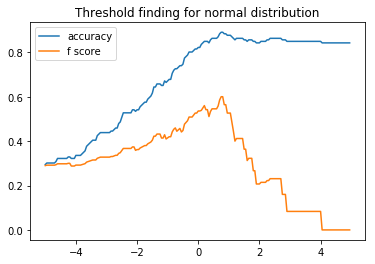

Best Accuracy: 89.04 % at Threshold 0.75
Best F-score: 60.00 % at Threshold 0.75


In [45]:
plt.title("Threshold finding for normal distribution")
plt.plot(np.arange(-5, 5, 0.05), y_acc)
plt.plot(np.arange(-5, 5, 0.05), y_fsc)
plt.legend(['accuracy', 'f score'])
plt.show()

print("Best Accuracy: %.2f %% at Threshold %.2f" % (max_acc*100, t_acc))
print("Best F-score: %.2f %% at Threshold %.2f" % (max_fsc*100, t_fsc))

## T16. Receiver Operating Characteristic (RoC) curve

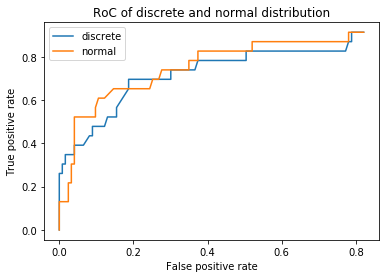

In [46]:
plt.title("RoC of discrete and normal distribution")
plt.plot(fpr_dis, tpr_dis)
plt.plot(fpr_nor, tpr_nor)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['discrete', 'normal'])
plt.show()

## T17. Change the number of discretization bins to 5

In [47]:
bin_edge = {}
llh_leave = {}
llh_stay = {}

for col in train_set:
    train_col_no_nan = train_set[~np.isnan(train_set[col])][col]
    train_col_no_nan = train_col_no_nan[train_col_no_nan != -1]

    leave = train_leave[~np.isnan(train_leave[col])][col]
    leave = leave[leave != -1]
    
    stay = train_stay[~np.isnan(train_stay[col])][col]
    stay = stay[stay != -1]

    hist, bin_edge[col] = np.histogram(train_col_no_nan, min(len(np.unique(train_col_no_nan)), 5))
    llh_leave[col] = np.histogram(leave, bin_edge[col], density=True)[0]
    llh_stay[col] = np.histogram(stay, bin_edge[col], density=True)[0]

In [48]:
log_h_d = {}

for i in range (len(test_set)):
    test = test_set[i:i+1]
    
    log_h_d[i] = np.log(p_leave) - np.log(p_stay)
    
    for col in train_set:
        value = test[col].values[0]
        
        if np.isnan(value) or value == -1:
            continue
            
        n_bin = np.digitize(value, bin_edge[col]) - 1
        n_bin = np.clip(n_bin, 0, len(bin_edge[col]) - 2)
        
        p_x_leave = llh_leave[col][n_bin]
        p_x_stay = llh_stay[col][n_bin]

        if p_x_leave > 0:
            log_h_d[i] += np.log(p_x_leave)
        if p_x_stay > 0:
            log_h_d[i] -= np.log(p_x_stay)

In [49]:
y_acc = []
y_fsc = []

fpr_dis_5 = []
tpr_dis_5 = []

max_acc = 0
t_acc = 0
max_fsc = 0
t_fsc = 0

for t in np.arange(-5, 5, 0.05):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i in range (len(test_set)):
        test = test_set[i:i+1]
        
        if test["Attrition"].values[0] == 1 and log_h_d[i] >= t:
            tp += 1
        elif test["Attrition"].values[0] == 0 and log_h_d[i] < t:
            tn += 1
        elif test["Attrition"].values[0] == 1 and log_h_d[i] < t:
            fn += 1
        elif test["Attrition"].values[0] == 0 and log_h_d[i] >= t:
            fp += 1
    
    acc, pre, rec, f_score, fp_rate = evaluate(tp, tn, fp, fn)
    
    y_acc += [acc]
    y_fsc += [f_score]
    
    fpr_dis_5 += [fp_rate]
    tpr_dis_5 += [rec]
    
    if acc > max_acc:
        max_acc = acc
        t_acc = t
    
    if f_score > max_fsc:
        max_fsc = f_score
        t_fsc = t

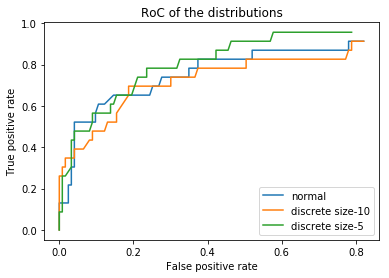

In [50]:
plt.title("RoC of the distributions")
plt.plot(fpr_nor, tpr_nor)
plt.plot(fpr_dis, tpr_dis)
plt.plot(fpr_dis_5, tpr_dis_5)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['normal', 'discrete size-10', 'discrete size-5'])
plt.show()

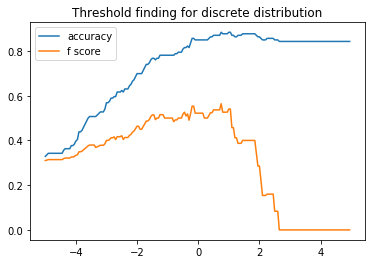

Best Accuracy: 88.36 % at Threshold 0.75
Best F-score: 56.41 % at Threshold 0.75


In [51]:
plt.title("Threshold finding for discrete distribution")
plt.plot(np.arange(-5, 5, 0.05), y_acc)
plt.plot(np.arange(-5, 5, 0.05), y_fsc)
plt.legend(['accuracy', 'f score'])
plt.show()

print("Best Accuracy: %.2f %% at Threshold %.2f" % (max_acc*100, t_acc))
print("Best F-score: %.2f %% at Threshold %.2f" % (max_fsc*100, t_fsc))

## OT3. Shuffle the database

### Discrete distribution

In [53]:
def naive_bayes_discrete(b_size):
    bin_edge = {}
    llh_leave = {}
    llh_stay = {}

    for col in train_set:
        train_col_no_nan = train_set[~np.isnan(train_set[col])][col]
        train_col_no_nan = train_col_no_nan[train_col_no_nan != -1]

        leave = train_leave[~np.isnan(train_leave[col])][col]
        leave = leave[leave != -1]

        stay = train_stay[~np.isnan(train_stay[col])][col]
        stay = stay[stay != -1]

        hist, bin_edge[col] = np.histogram(train_col_no_nan, min(len(np.unique(train_col_no_nan)), b_size))
        llh_leave[col] = np.histogram(leave, bin_edge[col], density=True)[0]
        llh_stay[col] = np.histogram(stay, bin_edge[col], density=True)[0]
        
    log_h_d = {}

    for i in range (len(test_set)):
        test = test_set[i:i+1]

        log_h_d[i] = np.log(p_leave) - np.log(p_stay)
        
        for col in train_set:
            value = test[col].values[0]

            if np.isnan(value) or value == -1:
                continue

            n_bin = np.digitize(value, bin_edge[col]) - 1
            n_bin = np.clip(n_bin, 0, len(bin_edge[col]) - 2)

            p_x_leave = llh_leave[col][n_bin]
            p_x_stay = llh_stay[col][n_bin]

            if p_x_leave > 0:
                log_h_d[i] += np.log(p_x_leave)
            if p_x_stay > 0:
                log_h_d[i] -= np.log(p_x_stay)

    max_acc = 0

    for t in np.arange(-5, 5, 0.05):
        tp = 0
        tn = 0
        fp = 0
        fn = 0

        for i in range (len(test_set)):
            test = test_set[i:i+1]

            if test["Attrition"].values[0] == 1 and log_h_d[i] >= t:
                tp += 1
            elif test["Attrition"].values[0] == 0 and log_h_d[i] < t:
                tn += 1
            elif test["Attrition"].values[0] == 1 and log_h_d[i] < t:
                fn += 1
            elif test["Attrition"].values[0] == 0 and log_h_d[i] >= t:
                fp += 1

        acc, pre, rec, f_score, fp_rate = evaluate(tp, tn, fp, fn)

        if acc > max_acc:
            max_acc = acc

    print("\tSize-%d bins --- Best Accuracy: %.2f %%" % (b_size, max_acc*100))

    return max_acc

In [54]:
accs = []
for r in range (1, 11):
    print("Round %d start" % r)
    
    data = data.sample(frac=1)
    
    attr_yes = data[data["Attrition"] == 1.0]
    attr_no = data[data["Attrition"] == 0.0]

    sy = attr_yes.shape[0] // 10
    sn = attr_no.shape[0] // 10

    test_set = pd.concat([attr_yes[:sy], attr_no[:sn]])
    train_set = pd.concat([attr_yes[sy:], attr_no[sn:]])

    train_leave = train_set[train_set["Attrition"] == 1.0]
    train_stay = train_set[train_set["Attrition"] == 0.0]

    train_set = train_set.drop(columns = "Attrition")
    
    max_acc = 0
    
    for b_size in np.arange(5, 21, 5):
        acc = naive_bayes_discrete(b_size)
        if acc > max_acc:
            max_acc = acc
            
    accs += [max_acc*100]
            
    print("Most accuracy: %.2f %%" % (max_acc*100))
    print("---------------------------------------------------------")

Round 1 start
	Size-5 bins --- Best Accuracy: 88.36 %
	Size-10 bins --- Best Accuracy: 86.99 %
	Size-15 bins --- Best Accuracy: 80.82 %
	Size-20 bins --- Best Accuracy: 83.56 %
Most accuracy: 88.36 %
---------------------------------------------------------
Round 2 start
	Size-5 bins --- Best Accuracy: 86.99 %
	Size-10 bins --- Best Accuracy: 85.62 %
	Size-15 bins --- Best Accuracy: 84.93 %
	Size-20 bins --- Best Accuracy: 86.30 %
Most accuracy: 86.99 %
---------------------------------------------------------
Round 3 start
	Size-5 bins --- Best Accuracy: 84.93 %
	Size-10 bins --- Best Accuracy: 83.56 %
	Size-15 bins --- Best Accuracy: 82.88 %
	Size-20 bins --- Best Accuracy: 81.51 %
Most accuracy: 84.93 %
---------------------------------------------------------
Round 4 start
	Size-5 bins --- Best Accuracy: 87.67 %
	Size-10 bins --- Best Accuracy: 85.62 %
	Size-15 bins --- Best Accuracy: 84.25 %
	Size-20 bins --- Best Accuracy: 84.25 %
Most accuracy: 87.67 %
--------------------------

In [58]:
print("Accuracy mean: %.2f %%" % np.mean(accs))
print("Accuracy std: %.2f" % np.std(accs))

Accuracy mean: 87.26 %
Accuracy std: 1.31


### Normal distribution

In [59]:
def naive_bayes_normal():
    leave_norm = {}
    stay_norm = {}
    
    for col in train_set:
        leave = train_leave[~np.isnan(train_leave[col])][col]
        leave = leave[leave != -1]

        stay = train_stay[~np.isnan(train_stay[col])][col]
        stay = stay[stay != -1]

        leave_norm[col] = norm(leave.mean(), leave.std())
        stay_norm[col] = norm(stay.mean(), stay.std())
        
    log_h_n = {}

    for i in range (len(test_set)):
        test = test_set[i:i+1]

        log_h_n[i] = np.log(p_leave) - np.log(p_stay)
    
        for col in train_set:
            value = test[col].values[0]
            
            if np.isnan(value) or value == -1:
                continue
            
            p_x_leave = leave_norm[col].pdf(value)
            p_x_stay = stay_norm[col].pdf(value)

            if p_x_leave > 0:
                log_h_n[i] += np.log(p_x_leave)
            if p_x_stay > 0:
                log_h_n[i] -= np.log(p_x_stay)

    max_acc = 0

    for t in np.arange(-5, 5, 0.05):
        tp = 0
        tn = 0
        fp = 0
        fn = 0

        for i in range (len(test_set)):
            test = test_set[i:i+1]

            if test["Attrition"].values[0] == 1 and log_h_n[i] >= t:
                tp += 1
            elif test["Attrition"].values[0] == 0 and log_h_n[i] < t:
                tn += 1
            elif test["Attrition"].values[0] == 1 and log_h_n[i] < t:
                fn += 1
            elif test["Attrition"].values[0] == 0 and log_h_n[i] >= t:
                fp += 1

        acc, pre, rec, f_score, fp_rate = evaluate(tp, tn, fp, fn)

        if acc > max_acc:
            max_acc = acc

    return max_acc

In [60]:
accs = []
for r in range (1, 11):
    data = data.sample(frac=1)
    
    attr_yes = data[data["Attrition"] == 1.0]
    attr_no = data[data["Attrition"] == 0.0]

    sy = attr_yes.shape[0] // 10
    sn = attr_no.shape[0] // 10

    test_set = pd.concat([attr_yes[:sy], attr_no[:sn]])
    train_set = pd.concat([attr_yes[sy:], attr_no[sn:]])

    train_leave = train_set[train_set["Attrition"] == 1.0]
    train_stay = train_set[train_set["Attrition"] == 0.0]

    train_set = train_set.drop(columns = "Attrition")
    
    acc = naive_bayes_normal()
    accs += [acc*100]
    
    print("Round %d --- Acc: %.2f %%" % (r, acc*100))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Round 1 --- Acc: 86.99 %
Round 2 --- Acc: 86.30 %
Round 3 --- Acc: 85.62 %
Round 4 --- Acc: 85.62 %
Round 5 --- Acc: 86.30 %
Round 6 --- Acc: 86.30 %
Round 7 --- Acc: 86.30 %
Round 8 --- Acc: 84.93 %
Round 9 --- Acc: 91.10 %
Round 10 --- Acc: 84.93 %


In [61]:
print("Accuracy mean: %.2f %%" % np.mean(accs))
print("Accuracy std: %.2f" % np.std(accs))

Accuracy mean: 86.44 %
Accuracy std: 1.67
